In [7]:
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

**CNN Architecture:**

`Input Image → Conv Layers → Pooling → Conv Layers → Pooling → Fully Connected → Output`

**Computer Vision Dataset**

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 346kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.30MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]


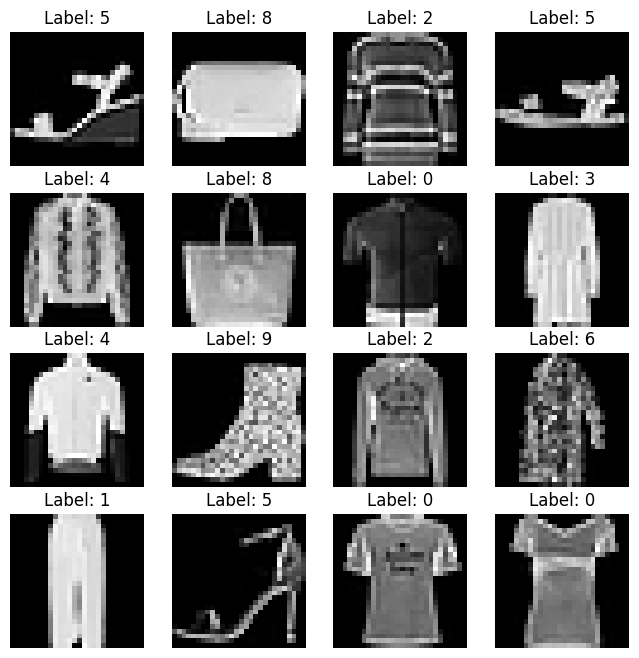

In [3]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),  # Convert PIL Image to tensor
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)


figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


**Mini-Batches and DataLoaders**

In [4]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle test data
    num_workers=0
)

for batch_X, batch_y in train_loader:
    print(f"Batch shape: {batch_X.shape}")  # [batch_size, channels, height, width]
    print(f"Labels shape: {batch_y.shape}")  # [batch_size]
    break

Batch shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])


**Training and Testing Loops**

In [5]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred == y).sum().item() / len(y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


In [6]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

**Creating a CNN**

In [9]:
class CNN(nn.Module):
    def __init__(self, input_shape, hidden_unit, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_unit * 7 * 7, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


model = CNN(input_shape=1, hidden_unit=10, output_shape=10)